## Thinkful Unsupervised Learning Capstone - "Analyzing Rideshare Trips in Chicago"
by Ilango Gopalan, December 2019

All trips, starting November 2018, reported by Transportation Network Providers (sometimes called rideshare companies) to the City of Chicago as part of routine reporting required by ordinance.

This project focuses on the recorded rideshare trips in Chicago from November 2018 through March 2019. The dataset has 1 million records, each representing a specific trip. 

**https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p**

I will be clustering this dataset using 4 different methods to determine which has the best score.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from itertools import cycle
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
pd.set_option('display.max_columns', 50)

In [2]:
chicago = pd.read_csv(('Chicago_Transportation_Network_Providers_Trips.csv'))
#The master file actually has 1 million records

In [3]:
date_split = chicago['Trip Start Timestamp'].str.split('/', expand=True)
#I want to focus on the month of the particular trip.

In [4]:
Trip_Month = date_split[0].astype(int)

In [5]:
chicago['Trip_Month'] = Trip_Month

In [6]:
chicago.head(1)

,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tip,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Trip_Month
0,7c3878e426b989a350e0938b5daba23ec9faf2d3,3/8/2019 10:45,3/8/2019 11:15,1909.0,10.6,NaN,NaN,62.0,32.0,20.0,3,2.55,25.55,False,1,41.792982,-87.724208,POINT (-87.7242081939 41.7929819032),41.878866,-87.625192,POINT (-87.6251921424 41.8788655841),3


# Data Cleaning

## Following to be dropped:

1. Trip ID
2. Pickup Census Tract
3. Dropff Census Tract
4. Pickup Community Area
5. Dropoff Community Area
6. Fare/Tip/Additional Charges
7. Shared Trip Authorized
8. Pickup Centroid Latitude/Pickup Centroid Longitude/Pickup Centroid Location/Dropoff Centroid Latitude/Dropoff Centroid/Longitude/Dropoff Centroid Location

###  'Trip Seconds' only has 45 missing values (0.0045% of all data), so I will drop the records

### I created the 'Trip_Month' feature which lists the month of the ride in integer form

In [7]:
chicago = chicago.dropna(how='any', subset=['Trip Seconds']) #Dropping the 45 missing records.  

In [8]:
chicago.columns

Index(['Trip ID', 'Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds',
       'Trip Miles', 'Pickup Census Tract', 'Dropoff Census Tract',
       'Pickup Community Area', 'Dropoff Community Area', 'Fare', 'Tip',
       'Additional Charges', 'Trip Total', 'Shared Trip Authorized',
       'Trips Pooled', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude',
       'Pickup Centroid Location', 'Dropoff Centroid Latitude',
       'Dropoff Centroid Longitude', 'Dropoff Centroid Location',
       'Trip_Month'],
      dtype='object')

In [9]:
chicago = chicago.drop(['Trip ID','Pickup Census Tract', 'Dropoff Census Tract',
       'Pickup Community Area', 'Dropoff Community Area', 'Fare', 'Tip',
       'Additional Charges', 'Shared Trip Authorized','Pickup Centroid Longitude',
       'Pickup Centroid Location', 'Dropoff Centroid Latitude',
       'Dropoff Centroid Longitude', 'Dropoff Centroid Location', 'Pickup Centroid Latitude' ], axis=1)

In [10]:
chicago.head(1)

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Trip Total,Trips Pooled,Trip_Month
0,3/8/2019 10:45,3/8/2019 11:15,1909.0,10.6,25.55,1,3


## Normalizing the features

In [11]:
scaler = MinMaxScaler()
scaler.fit(chicago[['Trip Seconds']])
chicago['Trip Seconds'] = scaler.transform(chicago[['Trip Seconds']])

scaler.fit(chicago[['Trip Miles']])
chicago['Trip Miles'] = scaler.transform(chicago[['Trip Miles']])

scaler.fit(chicago[['Trip Total']])
chicago['Trip Total'] = scaler.transform(chicago[['Trip Total']])

scaler.fit(chicago[['Trips Pooled']])
chicago['Trips Pooled'] = scaler.transform(chicago[['Trips Pooled']])


scaler.fit(chicago[['Trip_Month']])
chicago['Trip_Month'] = scaler.transform(chicago[['Trip_Month']])

C:\Users\ilang\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\ilang\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [12]:
chicago_sample = chicago.sample(frac=.01, random_state=99) 
#I'm taking a 1% sample of the dataset due to the high volume of records, so I can work with 10,485 rows

In [13]:
#Based on column info, I need to convert 'Trip Seconds' from object to float
chicago_sample["Trip Seconds"] = chicago["Trip Seconds"].astype(float)

In [14]:
chicago_sample.head(1)

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Trip Total,Trips Pooled,Trip_Month
1031041,1/29/2019 11:45,1/29/2019 11:45,0.010751,0.001316,0.004371,0.0,0.0


# NaN and blank values have been removed, we move to visualization.

### A scatter plot visualizing the duration of the ride compared to the money spent.  

**The outliers in this dataset do make sense, as a very long Uber/Lyft ride (5+ hours) would result in a higher than normal fare**

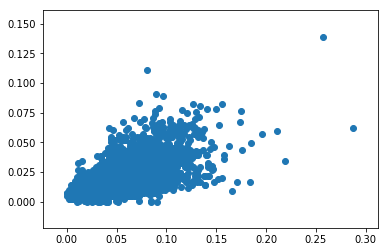

In [15]:
plt.scatter(chicago_sample["Trip Seconds"], chicago_sample["Trip Total"])

# Define X as my continuous features (all normalized) to be clustered

In [16]:
X = chicago_sample[['Trip Seconds', 'Trip Total', 'Trip Miles', 'Trips Pooled', 'Trip_Month']]

# KMeans Clustering

### I will begin with 3 clusters

In [17]:
n_clusters =3

In [18]:
km = KMeans(n_clusters) 
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [19]:
y_pred = km.fit_predict(chicago_sample[['Trip Seconds', 'Trip Total', 'Trip Miles', 'Trips Pooled', 'Trip_Month']])
y_pred

array([2, 2, 2, ..., 1, 2, 0])

In [20]:
chicago_sample['cluster'] = y_pred

chicago_sample.head()

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Trip Total,Trips Pooled,Trip_Month,cluster
1031041,1/29/2019 11:45,1/29/2019 11:45,0.010751,0.001316,0.004371,0.000000,0.000000,2
994118,2/11/2019 7:00,2/11/2019 7:00,0.012922,0.003949,0.006865,0.000000,0.090909,2
553259,2/24/2019 17:45,2/24/2019 18:00,0.032080,0.011846,0.011356,0.000000,0.090909,2
702775,1/28/2019 8:30,1/28/2019 8:45,0.054168,0.013162,0.004371,0.285714,0.000000,2
866455,1/19/2019 23:15,1/19/2019 23:15,0.024155,0.011517,0.009360,0.000000,0.000000,2


In [21]:
km = KMeans(X)
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=         Trip Seconds  Trip Total  Trip Miles  Trips Pooled  Trip_Month
1031041      0.010751    0.004371    0.001316      0.000000    0.000000
994118       0.012922    0.006865    0.003949      0.000000    0.090909
553259       0.032080    0.011356    0.011846      0.000000    0.090909
7...09
420683       0.071190    0.027322    0.041132      0.000000    0.181818

[10485 rows x 5 columns],
    n_init=10, n_jobs=None, precompute_distances='auto', random_state=None,
    tol=0.0001, verbose=0)

In [28]:
from sklearn import metrics
print(metrics.silhouette_score(chicago_sample[['Trip Seconds', 'Trip Total', 'Trip Miles', 'Trips Pooled', 'Trip_Month']], y_pred, metric='euclidean'))

0.5345542724795379


In [43]:
full_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X)

pd.crosstab(y_pred, full_pred) 

col_0,0,1,2
row_0,,,
0,3053,0,0
1,0,1856,0
2,0,0,5576


# MeanShift Clustering

In [47]:
from sklearn.cluster import MeanShift, estimate_bandwidth


ms = MeanShift()

ms_preds = ms.fit_predict(X)

metrics.silhouette_score(X, ms_preds, metric='euclidean')

0.7625048550036536

# Spectral Clustering

In [52]:
# Declare and fit the model.

sc = SpectralClustering(n_clusters = 3)

sc_preds = sc.fit_predict(X)

metrics.silhouette_score(X, sc_preds, metric='euclidean')

0.5706320488580467

# Affinity Propogation Clustering

In [55]:
af = AffinityPropagation()
af_preds = af.fit_predict(X)
metrics.silhouette_score(X, af_preds, metric='euclidean')

0.32456960829801074

# Evaluation

### 1. K Means was the easiest clustering model, but it didn't provide a cluster volume, I needed to guess on it.  Previously I used 12 clusters to attribute to the month of a specific ride, and that score wasn't reliable.  Now using 3 clusters, my score improved.  K Means also assumed my clusters were circular, but from comparing a scatter plot of length of trip to money spent, the visuals were more rectangular.  

### 2. MeanShift Clustering offers the highest score.  

### 3. Spectral Clustering had a better score than KMeans, but the cluster volume still had to be guessed.

### 4. Affinity Clustering took an extremely long time for 10,000 records over 5 features, but didn't require cluster volume.